<a href="https://colab.research.google.com/github/abkimc/CV-course-test-preparation/blob/main/Image_processing_lecture_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

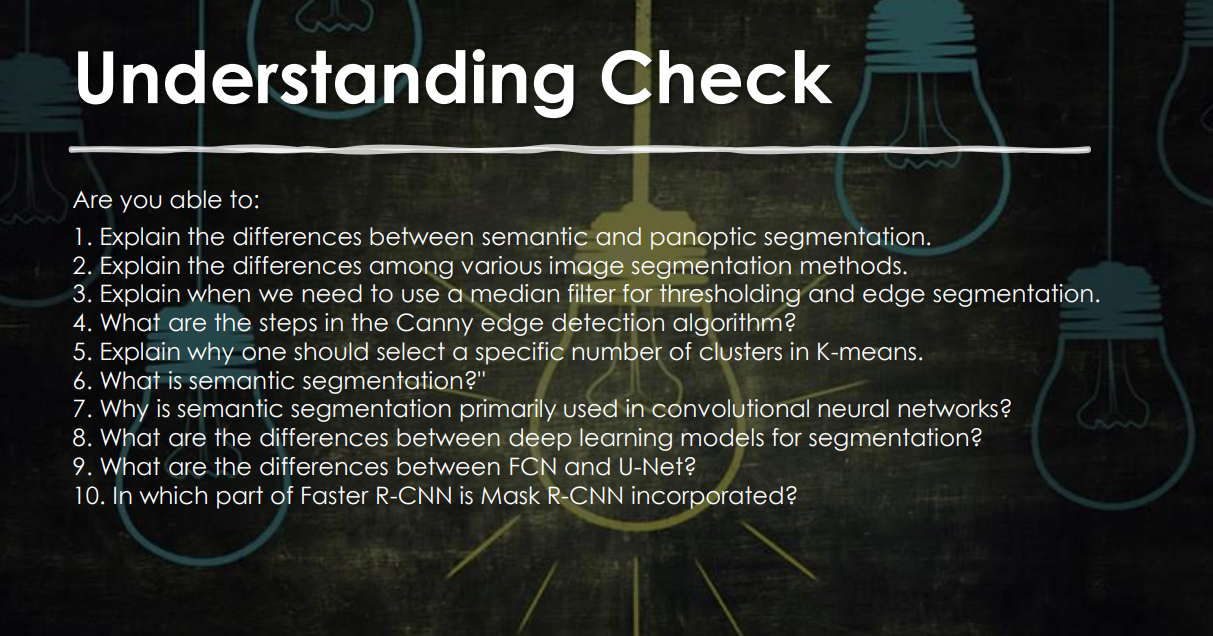

In [ ]:
# 1) Explain the differences between semantic and panoptic segmentation.

"""
Semantic segmentation assigns a class label to each pixel in an image, focusing on identifying "what" is in the image.
Panoptic segmentation combines semantic segmentation (class labels) and instance segmentation (individual object instances), providing a complete understanding of "what" and "how many" objects are present.
"""

# 2) Explain the differences among various image segmentation methods.

"""
Image segmentation methods include:
- Semantic segmentation: Classifies each pixel into a category.
- Instance segmentation: Identifies individual object instances and their boundaries.
- Panoptic segmentation: Combines semantic and instance segmentation.
- Thresholding: Separates regions based on pixel intensity values.
- Edge-based segmentation: Detects edges to separate objects.
- Region-based segmentation: Groups pixels based on similarity.
- Clustering-based segmentation: Uses algorithms like K-means to group pixels.
"""



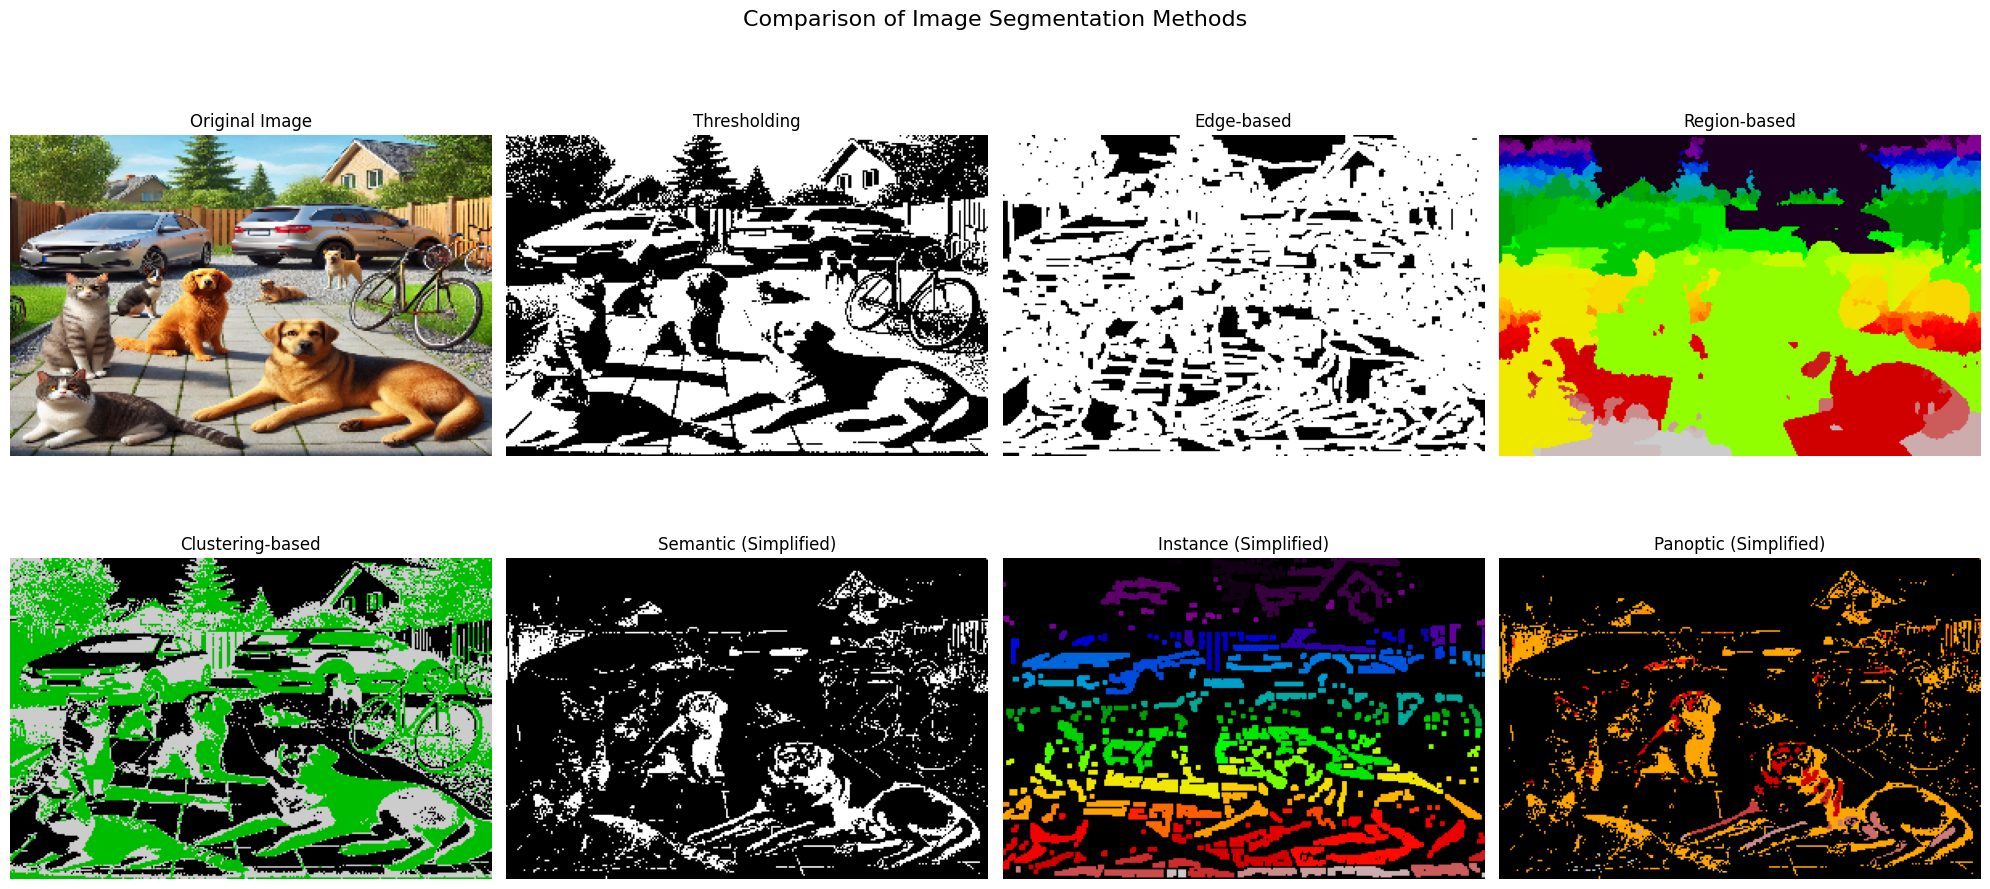

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, segmentation, color
from sklearn.cluster import KMeans
from scipy import ndimage
import cv2

def load_and_prepare_image(image_path=None):
    if image_path is None:
        # Use default image if no path provided
        img = data.coffee()
    else:
        # Load custom image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image to manageable size
    img = cv2.resize(img, (300, 200))
    return img

def threshold_segmentation(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def edge_based_segmentation(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 50, 150)
    # Dilate edges for better visibility
    kernel = np.ones((3,3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    return edges

def region_based_segmentation(image):
    # Convert to grayscale for watershed
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Create markers
    _, markers = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    markers = ndimage.label(markers)[0]

    # Apply watershed
    segments = segmentation.watershed(-gray, markers)
    return segments

def clustering_based_segmentation(image):
    # Reshape image for K-means
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Apply K-means
    k = 3
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pixel_values)

    # Reshape result back to image dimensions
    segmented = kmeans.labels_.reshape(image.shape[0:2])
    return segmented

def semantic_segmentation_simple(image):
    # This is a simplified version using color-based segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Define multiple color ranges for better segmentation
    color_ranges = [
        (np.array([0, 50, 50]), np.array([10, 255, 255])),  # Red
        (np.array([170, 50, 50]), np.array([180, 255, 255])),  # Red
        (np.array([20, 50, 50]), np.array([30, 255, 255])),  # Yellow
    ]

    # Combine masks
    combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    for lower, upper in color_ranges:
        mask = cv2.inRange(hsv, lower, upper)
        combined_mask = cv2.bitwise_or(combined_mask, mask)

    return combined_mask

def instance_segmentation_simple(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply adaptive thresholding
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

    # Remove noise
    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Find connected components
    num_labels, labels = cv2.connectedComponents(binary)
    return labels

def panoptic_segmentation_simple(image):
    semantic = semantic_segmentation_simple(image)
    instance = instance_segmentation_simple(image)

    panoptic = np.zeros_like(instance)
    panoptic[semantic > 0] = instance[semantic > 0] + 1000
    return panoptic

def plot_results(image):
    # Create figure with subplots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Comparison of Image Segmentation Methods', fontsize=16)

    # Original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image')

    # Thresholding
    thresh_result = threshold_segmentation(image)
    axes[0, 1].imshow(thresh_result, cmap='gray')
    axes[0, 1].set_title('Thresholding')

    # Edge-based
    edge_result = edge_based_segmentation(image)
    axes[0, 2].imshow(edge_result, cmap='gray')
    axes[0, 2].set_title('Edge-based')

    # Region-based
    region_result = region_based_segmentation(image)
    axes[0, 3].imshow(region_result, cmap='nipy_spectral')
    axes[0, 3].set_title('Region-based')

    # Clustering-based
    cluster_result = clustering_based_segmentation(image)
    axes[1, 0].imshow(cluster_result, cmap='nipy_spectral')
    axes[1, 0].set_title('Clustering-based')

    # Semantic
    semantic_result = semantic_segmentation_simple(image)
    axes[1, 1].imshow(semantic_result, cmap='gray')
    axes[1, 1].set_title('Semantic (Simplified)')

    # Instance
    instance_result = instance_segmentation_simple(image)
    axes[1, 2].imshow(instance_result, cmap='nipy_spectral')
    axes[1, 2].set_title('Instance (Simplified)')

    # Panoptic
    panoptic_result = panoptic_segmentation_simple(image)
    axes[1, 3].imshow(panoptic_result, cmap='nipy_spectral')
    axes[1, 3].set_title('Panoptic (Simplified)')

    # Remove axes for better visualization
    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def main(image_path=None):
    # Load image
    image = load_and_prepare_image("/content/picture.png")
    # Plot results
    plot_results(image)

if __name__ == "__main__":
    main()

In [ ]:
# 3) Explain when we need to use a median filter for thresholding and edge segmentation.

"""
A median filter is used to reduce noise in an image while preserving edges.
It is particularly useful in thresholding and edge segmentation when the image contains salt-and-pepper noise, which can distort intensity values and edges.
"""

# 4) What are the steps in the Canny edge detection algorithm?

"""
The Canny edge detection algorithm involves:
1. Noise reduction: Smooth the image using a Gaussian filter.
2. Gradient calculation: Compute intensity gradients using Sobel or similar operators.
3. Non-maximum suppression: Thin edges by keeping only local maxima in the gradient direction.
4. Double thresholding: Apply high and low thresholds to identify strong and weak edges.
5. Edge tracking: Retain weak edges connected to strong edges, removing isolated weak edges.
"""


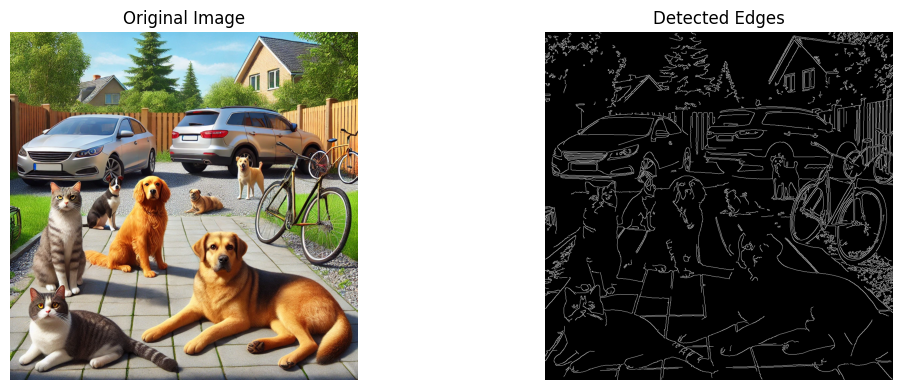

In [1]:
import numpy as np
import cv2
from google.colab import files
import matplotlib.pyplot as plt

def canny_edge_detection(image_path, low_threshold=100, high_threshold=200, sigma=1.0):
    """
    Implements Canny edge detection algorithm using OpenCV's optimized functions

    Parameters:
    image_path: str - Path to the input image
    low_threshold: int - Lower threshold for edge detection
    high_threshold: int - Higher threshold for edge detection
    sigma: float - Standard deviation for Gaussian filter

    Returns:
    numpy.ndarray: Image with detected edges
    """
    # Read the image and convert to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculate kernel size for Gaussian blur
    kernel_size = int(6 * sigma + 1)
    if kernel_size % 2 == 0:
        kernel_size += 1

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), sigma)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred,
                     threshold1=low_threshold,
                     threshold2=high_threshold,
                     apertureSize=3,
                     L2gradient=True)

    return edges

def show_results(original_path, edges):
    """Display original image and detected edges side by side"""
    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.imshow(cv2.cvtColor(cv2.imread(original_path), cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(edges, cmap='gray')
    plt.title('Detected Edges')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Upload an image


# Apply Canny edge detection
edges = canny_edge_detection('/content/picture.png',
                           low_threshold=100,
                           high_threshold=200,
                           sigma=1.0)

# Display results
show_results('/content/picture.png', edges)


In [ ]:

# 5) Explain why one should select a specific number of clusters in K-means.

"""
The number of clusters in K-means determines how the data is grouped. Selecting the right number is crucial because:
- Too few clusters can oversimplify the data, losing important patterns.
- Too many clusters can overfit the data, making it less generalizable.
Methods like the elbow method or silhouette score help determine the optimal number.
"""

# 6) What is semantic segmentation?

"""
Semantic segmentation is a computer vision task where each pixel in an image is assigned a class label, such as "car," "road," or "person."
It focuses on understanding the scene at the pixel level without distinguishing between individual instances of the same class.
"""

# 7) Why is semantic segmentation primarily used in convolutional neural networks?

"""
Convolutional Neural Networks (CNNs) are used for semantic segmentation because they can learn hierarchical features from images,
capturing both low-level (edges, textures) and high-level (shapes, objects) information.
Their ability to process spatial data makes them ideal for pixel-wise classification tasks.
"""

# 8) What are the differences between deep learning models for segmentation?

"""
Deep learning models for segmentation differ in architecture and purpose:
- FCN (Fully Convolutional Network): Replaces fully connected layers with convolutional layers for pixel-wise predictions.
- U-Net: Uses an encoder-decoder structure with skip connections for precise localization, commonly used in medical imaging.
- Mask R-CNN: Extends Faster R-CNN by adding a branch for pixel-wise mask prediction, combining object detection and instance segmentation.
- DeepLab: Uses atrous convolutions and spatial pyramid pooling to capture multi-scale context.
"""

# 9) What are the differences between FCN and U-Net?

"""
- FCN: Focuses on replacing fully connected layers with convolutional layers, suitable for general semantic segmentation but lacks precise localization.
- U-Net: Features an encoder-decoder architecture with skip connections, enabling precise localization and high accuracy, especially in medical imaging.
"""

# 10) In which part of Faster R-CNN is Mask R-CNN incorporated?

"""
Mask R-CNN is incorporated into the Region of Interest (RoI) pooling layer of Faster R-CNN.
It adds a parallel branch to predict pixel-wise segmentation masks for each detected object, alongside the existing classification and bounding box regression branches.
"""


# SAM example

In [4]:
# Install required packages
!pip install segment-anything
!pip install torch torchvision
!pip install opencv-python

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os

def download_sam_model():
    """Download the SAM model if not already present"""
    if not os.path.exists("sam_vit_h_4b8939.pth"):
        !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

def load_sam_model():
    """Load the SAM model"""
    sam_checkpoint = "sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    device = "cuda" if torch.cuda.is_available() else "cpu"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    return sam

def generate_masks(image_path, sam):
    """Generate masks for the input image"""
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create mask generator
    mask_generator = SamAutomaticMaskGenerator(sam)

    # Generate masks
    masks = mask_generator.generate(image)

    return image, masks

def show_segmentation_result(image, masks):
    """Show the overall segmentation result"""
    # Create a colored overlay for all masks
    overlay = np.zeros_like(image)

    for idx, mask_data in enumerate(masks):
        color = np.random.rand(3)
        overlay[mask_data['segmentation']] = color * 255

    # Blend the original image with the overlay
    result = cv2.addWeighted(image, 0.7, overlay.astype(np.uint8), 0.3, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(result)
    plt.title("Segmentation Result")
    plt.axis('off')
    plt.show()

def show_individual_masks(image, masks):
    """Show up to 15 individual masks in separate plots"""
    # Limit the number of masks to 15
    masks = masks[:15]

    # Calculate the grid size
    n_masks = len(masks)
    n_cols = 3
    n_rows = (n_masks + n_cols - 1) // n_cols

    plt.figure(figsize=(15, 5 * n_rows))

    for idx, mask_data in enumerate(masks):
        plt.subplot(n_rows, n_cols, idx + 1)

        # Create mask overlay
        mask_overlay = np.zeros_like(image)
        color = np.random.rand(3)
        mask_overlay[mask_data['segmentation']] = color * 255

        # Blend original image with mask
        result = cv2.addWeighted(image, 0.7, mask_overlay.astype(np.uint8), 0.3, 0)

        plt.imshow(result)
        plt.title(f"Mask {idx + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [6]:
# Download and load the model
download_sam_model()
sam = load_sam_model()

# Process an image
image_path = "picture.png"
image, masks = generate_masks(image_path, sam)


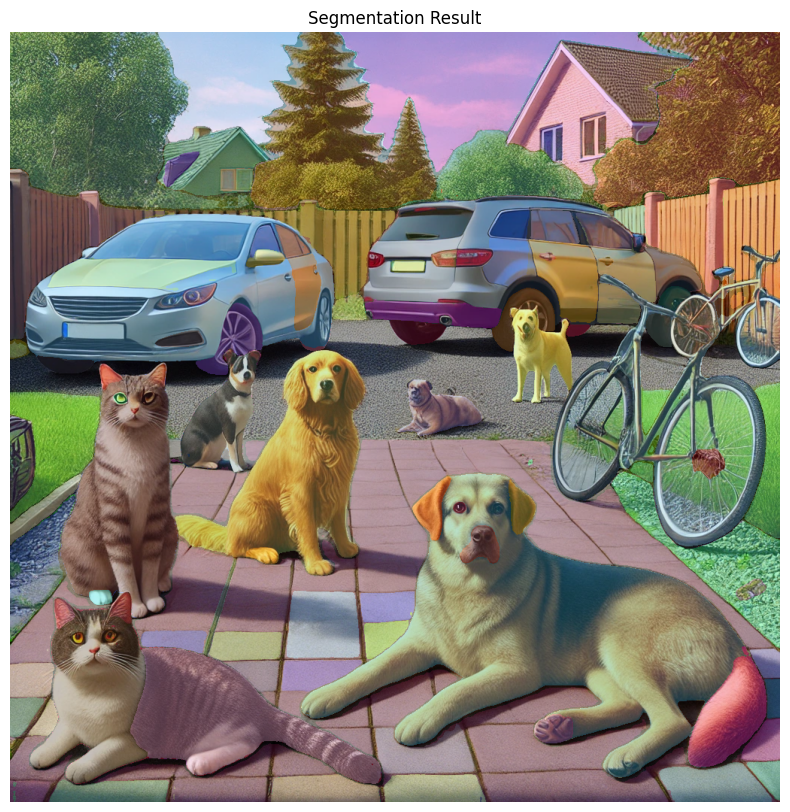

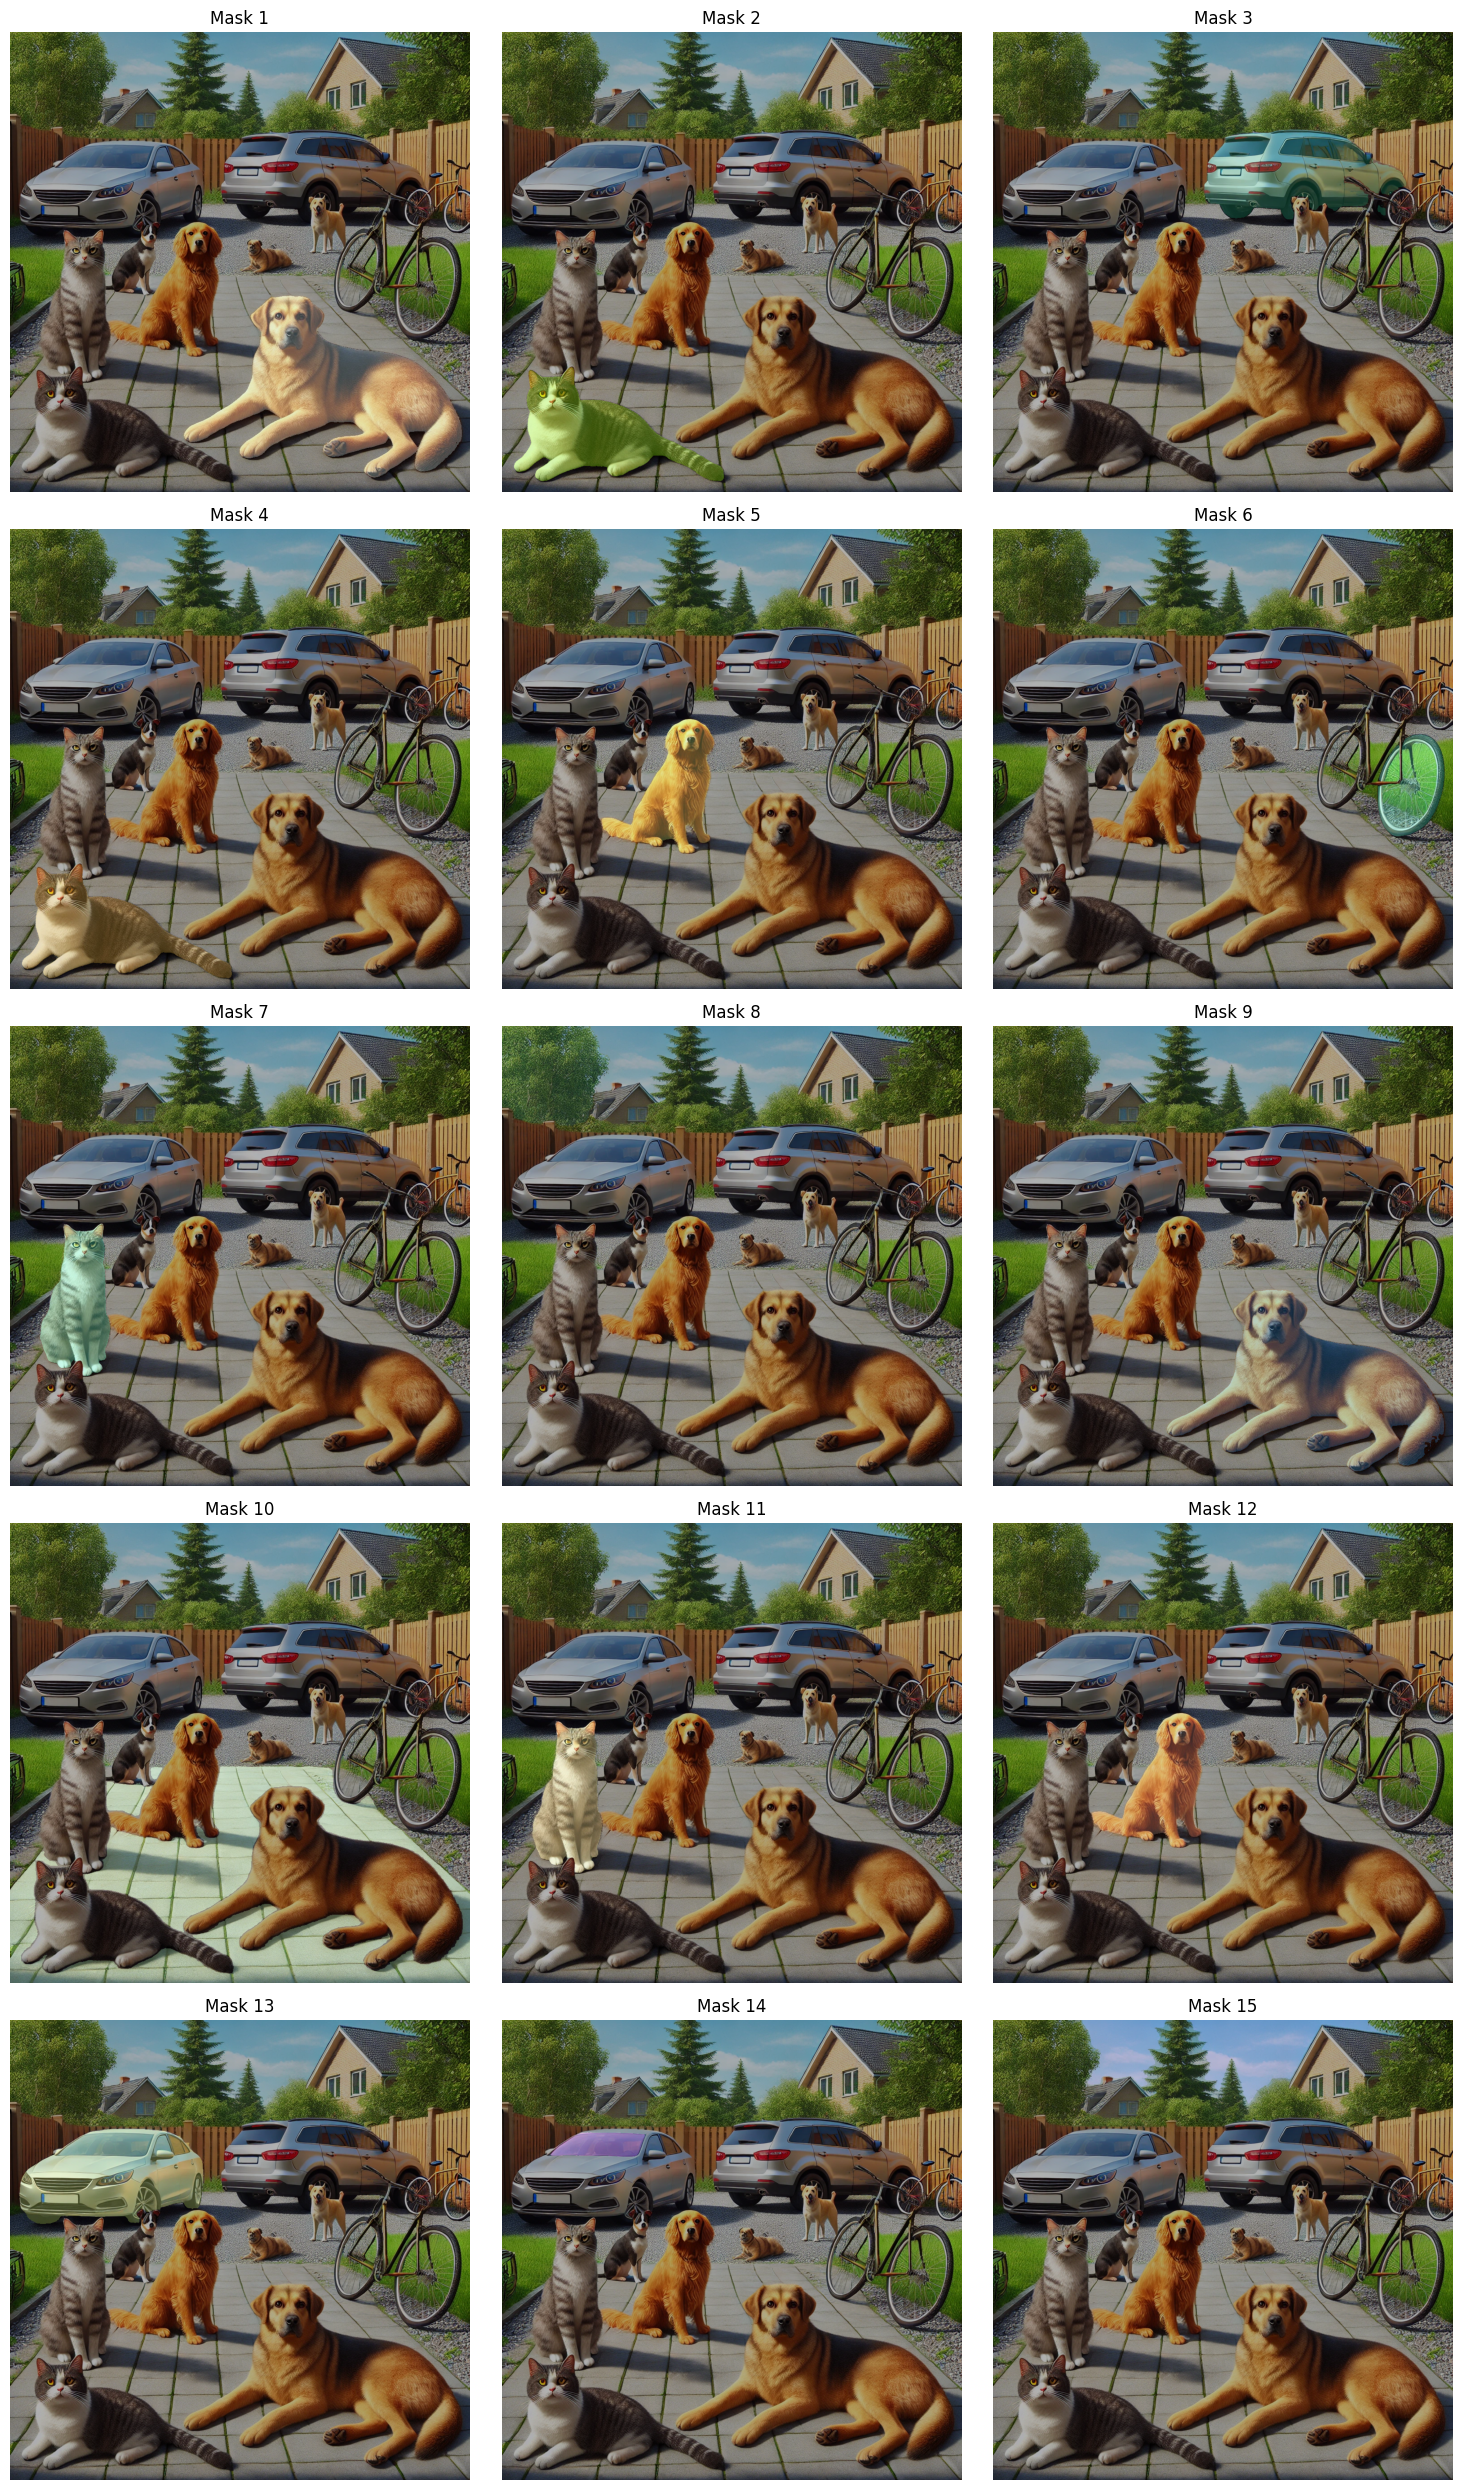

In [7]:
# Show results
show_segmentation_result(image, masks)
show_individual_masks(image, masks)
